In [1]:
import ee
from concurrent.futures import as_completed, ProcessPoolExecutor
import glob
import geopandas as gpd
import matplotlib
import numpy as np
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    classification_report,
    ConfusionMatrixDisplay,
)
from soiltexture import getTextures
from tqdm.notebook import tqdm

## Get Earth Engine Running
To access GEE, we will need to authenticate our account, )&( then initialize a connection to a server. 

In [2]:
SERVICE_ACCOUNT = "refit-fvs@refit-fvs.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(SERVICE_ACCOUNT, "../../gee_key.json")
ee.Initialize(credentials)

# Retrieve Soil Texture Data
For each of the plots in a GeoDataFrame, and each year the imagery are available, we will filter the NASA Soil Moisture Active Passive (SMAP) collection from GEE to our Area of Interest. We want to get a monthly time-series of soil profile moisture for each point.

In [3]:
DATA_DIR = "../../data/"
PLOTS = os.path.join(DATA_DIR, "interim", "plot_info_for_climatena.csv")
plots = pd.read_csv(PLOTS).rename({"ID1": "PLOT_ID"}, axis=1).drop(["ID2"], axis=1)
plots.head()

,PLOT_ID,lat,lon,el
0,60101550679,41.806228,-123.788726,761
1,60101551744,41.980638,-124.193526,91
2,60101551969,41.681432,-123.803842,701
3,60101552953,41.938125,-123.870868,640
4,60101553315,41.738938,-123.783382,1432


In [4]:
plots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PLOT_ID  12156 non-null  int64  
 1   lat      12156 non-null  float64
 2   lon      12156 non-null  float64
 3   el       12156 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 380.0 KB


## Collection Processing Functions
The following functions work on Google Earth Engine ImageCollections. 

In [5]:
SOILS = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")


def get_soil_texture(x, y, buffer=1, epsg=4326):
    aoi = ee.Geometry.Point(x, y, epsg=epsg)
    result = SOILS.reduceRegion(
        reducer=ee.Reducer.mode(),
        geometry=aoi.buffer(buffer),
        crs=f"EPSG:{epsg}",
        scale=1,
    )
    return result.getInfo()


def get_soil_df(point_id, x, y, buffer=1, epsg=4326):
    values = get_soil_texture(x, y, buffer=buffer, epsg=epsg)
    df = pd.DataFrame(
        data=values, dtype=int, index=pd.Series(point_id, name="PLOT_ID", dtype=int)
    )
    while df.isna().values.sum() > 0:
        buffer += 10
        buffer = (buffer // 10) * 10
        values = get_soil_texture(x, y, buffer=buffer, epsg=epsg)
        df = pd.DataFrame(
            data=values, dtype=int, index=pd.Series(point_id, name="PLOT_ID", dtype=int)
        )
    return df

In [6]:
sand = ee.Image("projects/soilgrids-isric/sand_mean")
silt = ee.Image("projects/soilgrids-isric/silt_mean")
clay = ee.Image("projects/soilgrids-isric/clay_mean")


def get_isric_texture(x, y, buffer=1, epsg=4326):
    aoi = ee.Geometry.Point(x, y, epsg=epsg)
    sand_result = sand.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.buffer(buffer),
        crs=f"EPSG:{epsg}",
        scale=1,
    )
    silt_result = silt.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.buffer(buffer),
        crs=f"EPSG:{epsg}",
        scale=1,
    )

    clay_result = clay.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=aoi.buffer(buffer),
        crs=f"EPSG:{epsg}",
        scale=1,
    )
    return {**sand_result.getInfo(), **silt_result.getInfo(), **clay_result.getInfo()}


def get_isric_df(point_id, x, y, buffer=1, epsg=4326):
    values = get_isric_texture(x, y, buffer=buffer, epsg=epsg)
    df = pd.DataFrame(
        data=values, dtype=int, index=pd.Series(point_id, name="PLOT_ID", dtype=int)
    )
    while df.isna().values.sum() > 0 and buffer < 500:
        buffer += 10
        buffer = (buffer // 10) * 10
        values = get_isric_texture(x, y, buffer=buffer, epsg=epsg)
        df = pd.DataFrame(
            data=values, dtype=int, index=pd.Series(point_id, name="PLOT_ID", dtype=int)
        )
    df.columns = [col.replace("_mean", "") for col in df.columns]
    return df

In [7]:
OVERWRITE = False
results = []

ALREADY_DONE = os.path.join(DATA_DIR, "interim", "soil_types.csv")
if os.path.exists(ALREADY_DONE) and not OVERWRITE:
    already_done = pd.read_csv(ALREADY_DONE).set_index("PLOT_ID")
    results.append(already_done)
    already_done_plots = np.unique(already_done.index.get_level_values(0))
else:
    already_done_plots = []

with ProcessPoolExecutor(40) as executor:
    print("Starting to get data from Google Earth Engine.")
    jobs = [
        executor.submit(get_soil_df, *[row["PLOT_ID"], row["lon"], row["lat"]])
        for _, row in plots.iterrows()
        if row["PLOT_ID"] not in already_done_plots
    ]

    for job in tqdm(as_completed(jobs), total=len(jobs)):
        results.append(job.result())

COL_ORDER = ["b0", "b10", "b30", "b60", "b100", "b200"]
result_df = pd.concat(results, axis=0)[COL_ORDER].dropna()
out_csv = os.path.join(DATA_DIR, "interim", "soil_types.csv")
result_df.to_csv(out_csv, index=True, header=True)
result_df.info()

Starting to get data from Google Earth Engine.


0it [00:00, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   b0      12156 non-null  int64
 1   b10     12156 non-null  int64
 2   b30     12156 non-null  int64
 3   b60     12156 non-null  int64
 4   b100    12156 non-null  int64
 5   b200    12156 non-null  int64
dtypes: int64(6)
memory usage: 664.8 KB


In [8]:
OVERWRITE = False
isric_results = []

ALREADY_DONE = os.path.join(DATA_DIR, "interim", "isric_soil_types.csv")
if os.path.exists(ALREADY_DONE) and not OVERWRITE:
    already_done = pd.read_csv(ALREADY_DONE).set_index("PLOT_ID")
    isric_results.append(already_done)
    already_done_plots = np.unique(already_done.index.get_level_values(0))
else:
    already_done_plots = []

with ProcessPoolExecutor(40) as executor:
    print("Starting to get data from Google Earth Engine.")
    jobs = [
        executor.submit(get_isric_df, *[row["PLOT_ID"], row["lon"], row["lat"]])
        for _, row in plots.iterrows()
        if row["PLOT_ID"] not in already_done_plots
    ]

    for job in tqdm(as_completed(jobs), total=len(jobs)):
        isric_results.append(job.result())

isric_result_df = pd.concat(isric_results, axis=0).dropna()

CROSSWALK = {
    "clay": 1,
    "silty clay": 2,
    "silty clay loam": 5,
    "sandy clay": 3,
    "sandy clay loam": 6,
    "clay loam": 4,
    "silt": 10,
    "silt loam": 8,
    "loam": 7,
    "sand": 12,
    "loamy sand": 11,
    "sandy loam": 9,
}
crosswalk = pd.Series(CROSSWALK, name="SOIL_TYPE")

for depth in ["0-5", "5-15", "15-30", "30-60", "60-100", "100-200"]:
    isric_result_df[f"texture_{depth}cm"] = getTextures(
        isric_result_df[f"sand_{depth}cm"].values / 10.0,
        isric_result_df[f"clay_{depth}cm"].values / 10.0,
    )
    isric_result_df[f"soiltype_{depth}cm"] = crosswalk.reindex(
        isric_result_df[f"texture_{depth}cm"].values
    ).values

out_csv = os.path.join(DATA_DIR, "interim", "isric_soil_types.csv")
isric_result_df.to_csv(out_csv, index=True, header=True)
isric_result_df.info()

Starting to get data from Google Earth Engine.


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12153 entries, 60101551969 to 530907572668
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sand_0-5cm          12153 non-null  float64
 1   sand_100-200cm      12153 non-null  float64
 2   sand_15-30cm        12153 non-null  float64
 3   sand_30-60cm        12153 non-null  float64
 4   sand_5-15cm         12153 non-null  float64
 5   sand_60-100cm       12153 non-null  float64
 6   silt_0-5cm          12153 non-null  float64
 7   silt_100-200cm      12153 non-null  float64
 8   silt_15-30cm        12153 non-null  float64
 9   silt_30-60cm        12153 non-null  float64
 10  silt_5-15cm         12153 non-null  float64
 11  silt_60-100cm       12153 non-null  float64
 12  clay_0-5cm          12153 non-null  float64
 13  clay_100-200cm      12153 non-null  float64
 14  clay_15-30cm        12153 non-null  float64
 15  clay_30-60cm        12153 non-null  

In [9]:
compare = pd.merge(
    result_df["b10"],
    isric_result_df["soiltype_5-15cm"],
    left_index=True,
    right_index=True,
    how="inner",
)
compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12153 entries, 60101550679 to 530907572668
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   b10              12153 non-null  int64
 1   soiltype_5-15cm  12153 non-null  int64
dtypes: int64(2)
memory usage: 284.8 KB


In [10]:
LABELS = {
    1: "C",
    2: "TC",
    3: "SC",
    4: "CL",
    5: "TCL",
    6: "SCL",
    7: "L",
    8: "TL",
    9: "SL",
    10: "T",
    11: "LS",
    12: "S",
}
labels = pd.Series(LABELS, name="SOIL_TYPE")

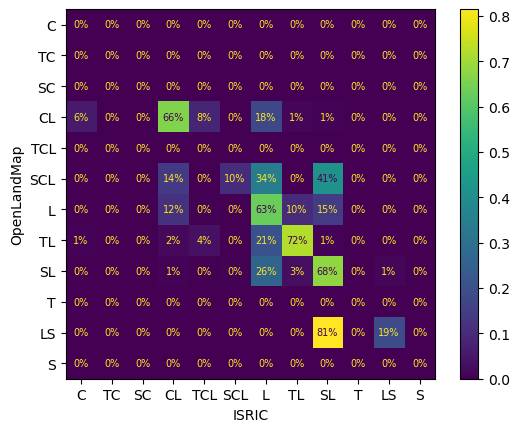

In [11]:
disp = ConfusionMatrixDisplay.from_predictions(
    compare["b10"],
    compare["soiltype_5-15cm"],
    normalize="true",  # normed by OpenLandMap preds
    labels=labels.index,
    display_labels=labels.values,
    values_format=",.0%",
)

for child in disp.ax_.get_children():
    if isinstance(child, matplotlib.text.Text):
        child.set_fontsize(7)

disp.ax_.set(xlabel="ISRIC", ylabel="OpenLandMap");

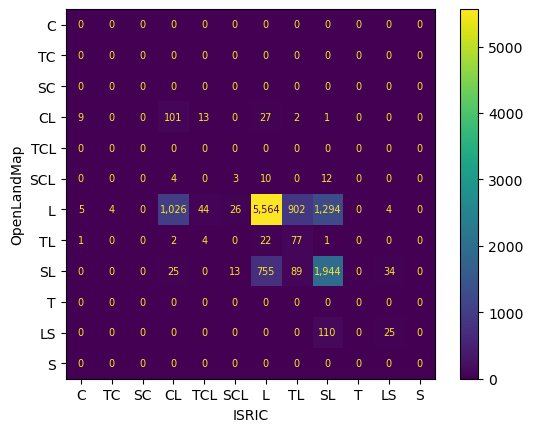

In [17]:
disp = ConfusionMatrixDisplay.from_predictions(
    compare["b10"],
    compare["soiltype_5-15cm"],
    normalize=None,
    labels=labels.index,
    display_labels=labels.values,
    values_format=",.0f",
)

for child in disp.ax_.get_children():
    if isinstance(child, matplotlib.text.Text):
        child.set_fontsize(7)

disp.ax_.set(xlabel="ISRIC", ylabel="OpenLandMap");

In [16]:
print("Acc:", accuracy_score(compare["b10"], compare["soiltype_5-15cm"]))
print(
    "Kappa:",
    cohen_kappa_score(compare["b10"], compare["soiltype_5-15cm"], weights="linear"),
)
print(
    classification_report(
        compare["b10"],
        compare["soiltype_5-15cm"],
        labels=labels.index,
        target_names=labels.values,
        zero_division=0,
    )
)

Acc: 0.6347403933185222
Kappa: 0.38182444965446216
              precision    recall  f1-score   support

           C       0.00      0.00      0.00         0
          TC       0.00      0.00      0.00         0
          SC       0.00      0.00      0.00         0
          CL       0.09      0.66      0.15       153
         TCL       0.00      0.00      0.00         0
         SCL       0.07      0.10      0.08        29
           L       0.87      0.63      0.73      8869
          TL       0.07      0.72      0.13       107
          SL       0.58      0.68      0.62      2860
           T       0.00      0.00      0.00         0
          LS       0.40      0.19      0.25       135
           S       0.00      0.00      0.00         0

   micro avg       0.63      0.63      0.63     12153
   macro avg       0.17      0.25      0.16     12153
weighted avg       0.78      0.63      0.69     12153

